# SegNet

Framework: Pytorch<br>
Dataset:   2016ISIC dataset

In [1]:
# to run the program on a specific GPU. AS my GPU 0 is not available
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
device = torch.device('cuda')

In [2]:
print(torch.cuda.current_device())

0


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# import torch
from torch.autograd import Variable
from __future__ import print_function
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import save_image
import os
from PIL import Image
!pip install xlsxwriter 
import xlsxwriter

     |████████████████████████████████| 149 kB 12.4 MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.chdir('/content/drive/MyDrive/segmentation/SegNet')

# DATASET ISIC
All the Images in the X_TRAINING dataset have different size so all images need to reshaped <br>
e.g. (x, y, 3)<br>
While all the images in the Y_TRAINING dataset has shape (224, 224)<br>
All the images in the X_test dataset are of the shape (224, 224, 3)<br>
And all the images in the Y_test datatset are of shape(224, 224)

In [6]:
#Loading Train data

class Isic_train_Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "ISBI2016_ISIC_Part0_Training_Data"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "ISBI2016_ISIC_Part0_Training_GroundTruth"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "ISBI2016_ISIC_Part0_Training_Data", self.imgs[idx])
        mask_path = os.path.join(self.root, "ISBI2016_ISIC_Part0_Training_GroundTruth", self.masks[idx])
        img = Image.open(img_path)#.convert("RGB")
#         img = img.resize((224, 224))
        mask = Image.open(mask_path)
#         mask = mask.resize((224, 224))

        if self.transforms is not None:
            img = self.transforms(img)
            mask = self.transforms(mask)
            

        return img, mask

    def __len__(self):
        return len(self.imgs)

In [7]:
#Loading Train data

class Isic_test_Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "ISBI2016_ISIC_Part0_Test_Data"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "ISBI2016_ISIC_Part0_Test_GroundTruth"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "ISBI2016_ISIC_Part0_Test_Data", self.imgs[idx])
        mask_path = os.path.join(self.root, "ISBI2016_ISIC_Part0_Test_GroundTruth", self.masks[idx])
        img = Image.open(img_path)#.convert("RGB")
#         img = img.resize((224, 224))
        mask = Image.open(mask_path)
#         mask = mask.resize((224, 224))

        if self.transforms is not None:
            img = self.transforms(img)
            mask = self.transforms(mask)
            
        img_name = self.imgs[idx]
        return img, mask, img_name

    def __len__(self):
        return len(self.imgs)

In [8]:
def my_segmentation_transforms(image):
    angle = 25
    image = TF.rotate(image, angle)
    return image

def scale_image(image):
#     scale = 1.2
    image = TF.affine(img=image, angle=0, translate=(0, 0), scale=1.3, shear=0)
    return image

In [9]:
transform1 = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])#transforms.Resize((224,224)),
transform2 = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(1), transforms.ToTensor()])
transform3 = transforms.Compose([transforms.Resize((224,224)), my_segmentation_transforms, transforms.ToTensor()])
transform4 = transforms.Compose([transforms.Resize((224,224)), scale_image, transforms.ToTensor()])

train_dataset     = Isic_train_Dataset('/content/drive/MyDrive/segmentation/SegNet/one_result/', transforms=transform1)
horizontalflipped = Isic_train_Dataset('/content/drive/MyDrive/segmentation/SegNet/one_result/', transforms=transform2)
rotated_image     = Isic_train_Dataset('/content/drive/MyDrive/segmentation/SegNet/one_result/', transforms=transform3)
scaled_image      = Isic_train_Dataset('/content/drive/MyDrive/segmentation/SegNet/one_result/', transforms=transform4)
# data Augmentation

In [10]:
test_dataset = Isic_test_Dataset('/content/drive/MyDrive/segmentation/SegNet/one_result', transforms=transform1)

In [11]:
increased_dataset = torch.utils.data.ConcatDataset([train_dataset, horizontalflipped, rotated_image, scaled_image])

In [12]:
#shape of train Data
img, mask = train_dataset[0]
print(img.size())
print(mask.size())

torch.Size([3, 224, 224])
torch.Size([1, 224, 224])


In [13]:
len(increased_dataset), len(increased_dataset)*0.9, len(increased_dataset)*0.1

(3600, 3240.0, 360.0)

In [14]:
lengths = [int(len(increased_dataset)*0.9), int(len(increased_dataset)*0.1)]
train_set, val_set = torch.utils.data.dataset.random_split(increased_dataset, lengths)

In [15]:
# hyper-parameters
batch_size = 8

In [16]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [17]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [18]:
# lengths of dataset
print('Length of original train data : ', len(train_dataset))
print('Length of Training data       : ', len(train_set))
print('Length of validation data     : ', len(val_set))
print('Length of Testing data        : ', len(test_dataset))

Length of original train data :  900
Length of Training data       :  3240
Length of validation data     :  360
Length of Testing data        :  379


# visualizing Data

torch.Size([8, 3, 224, 224])
torch.Size([8, 1, 224, 224])


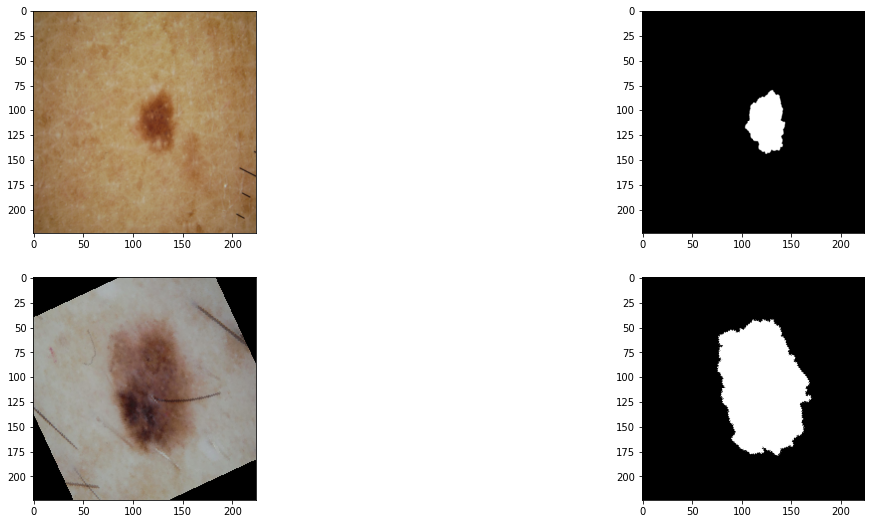

In [19]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

plt.figure(figsize=(20,9))
plt.subplot(2,2,1)
plt.imshow(images[0].permute(1, 2, 0))
plt.subplot(2,2,2)
plt.imshow(labels[0].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
plt.subplot(2,2,3)
plt.imshow(images[1].permute(1, 2, 0))
plt.subplot(2,2,4)
plt.imshow(labels[1].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
# f, axarr = plt.subplots(2,2)
# axarr[0,0].imshow(images[0].permute(1, 2, 0)  )
# axarr[0,1].imshow(labels[0].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
# axarr[1,0].imshow(images[1].permute(1, 2, 0)  )
# axarr[1,1].imshow(labels[1].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
# axarr[2,0].imshow(images[2].permute(1, 2, 0)  )
# axarr[2,1].imshow(labels[2].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
# axarr[3,0].imshow(images[3].permute(1, 2, 0)  )
# axarr[3,1].imshow(labels[3].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')

In [20]:
# import torchsummary
class SegNet(nn.Module):
    def __init__(self,classes= 1):
        super(SegNet, self).__init__()

        batchNorm_momentum = 0.1

        self.conv11 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128, momentum= batchNorm_momentum)
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128, momentum= batchNorm_momentum)

        self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)

        self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv53d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv52d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv51d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv43d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv42d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv41d = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)

        self.conv33d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv32d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv31d = nn.Conv2d(256,  128, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(128, momentum= batchNorm_momentum)

        self.conv22d = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(128, momentum= batchNorm_momentum)
        self.conv21d = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv12d = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        self.conv11d = nn.Conv2d(64, classes, kernel_size=3, padding=1)


    def forward(self, x):

        # Stage 1
        x11 = F.relu(self.bn11(self.conv11(x)))
        x12 = F.relu(self.bn12(self.conv12(x11)))
        x1_size = x12.size()
        x1p, id1 = F.max_pool2d(x12,kernel_size=2, stride=2,return_indices=True)

        # Stage 2
        x21 = F.relu(self.bn21(self.conv21(x1p)))
        x22 = F.relu(self.bn22(self.conv22(x21)))
        x2_size = x22.size()
        x2p, id2 = F.max_pool2d(x22,kernel_size=2, stride=2,return_indices=True)

        # Stage 3
        x31 = F.relu(self.bn31(self.conv31(x2p)))
        x32 = F.relu(self.bn32(self.conv32(x31)))
        x33 = F.relu(self.bn33(self.conv33(x32)))
        x3_size = x33.size()
        x3p, id3 = F.max_pool2d(x33,kernel_size=2, stride=2,return_indices=True)

        # Stage 4
        x41 = F.relu(self.bn41(self.conv41(x3p)))
        x42 = F.relu(self.bn42(self.conv42(x41)))
        x43 = F.relu(self.bn43(self.conv43(x42)))
        x4_size = x43.size()
        x4p, id4 = F.max_pool2d(x43,kernel_size=2, stride=2,return_indices=True)

        # Stage 5
        x51 = F.relu(self.bn51(self.conv51(x4p)))
        x52 = F.relu(self.bn52(self.conv52(x51)))
        x53 = F.relu(self.bn53(self.conv53(x52)))
        x5_size = x53.size()
        x5p, id5 = F.max_pool2d(x53,kernel_size=2, stride=2,return_indices=True)


        # Stage 5d
        x5d = F.max_unpool2d(x5p, id5, kernel_size=2, stride=2, output_size=x5_size)
        x53d = F.relu(self.bn53d(self.conv53d(x5d)))
        x52d = F.relu(self.bn52d(self.conv52d(x53d)))
        x51d = F.relu(self.bn51d(self.conv51d(x52d)))

        # Stage 4d
        x4d = F.max_unpool2d(x51d, id4, kernel_size=2, stride=2, output_size=x4_size)
        x43d = F.relu(self.bn43d(self.conv43d(x4d)))
        x42d = F.relu(self.bn42d(self.conv42d(x43d)))
        x41d = F.relu(self.bn41d(self.conv41d(x42d)))

        # Stage 3d
        x3d = F.max_unpool2d(x41d, id3, kernel_size=2, stride=2, output_size=x3_size)
        x33d = F.relu(self.bn33d(self.conv33d(x3d)))
        x32d = F.relu(self.bn32d(self.conv32d(x33d)))
        x31d = F.relu(self.bn31d(self.conv31d(x32d)))

        # Stage 2d
        x2d = F.max_unpool2d(x31d, id2, kernel_size=2, stride=2, output_size=x2_size)
        x22d = F.relu(self.bn22d(self.conv22d(x2d)))
        x21d = F.relu(self.bn21d(self.conv21d(x22d)))

        # Stage 1d
        x1d = F.max_unpool2d(x21d, id1, kernel_size=2, stride=2, output_size=x1_size)
        x12d = F.relu(self.bn12d(self.conv12d(x1d)))
        x11d = F.sigmoid(self.conv11d(x12d))

        return x11d

    def load_from_segnet(self, model_path):
        s_dict = self.state_dict()# create a copy of the state dict
        th = torch.load(model_path).state_dict() # load the weigths
        # for name in th:
            # s_dict[corresp_name[name]] = th[name]
        self.load_state_dict(th)



# """print layers and params of network"""
# if __name__ == '__main__':
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = SegNet(classes=1).to(device)
# #     torchsummary.summary(model,(3,224,224))


In [21]:
learning_rate = 0.001
from torchsummary import summary
model = SegNet().to(device)
print(model)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)#, momentum = 0.9, weight_decay = 0.005
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5, last_epoch=-1, verbose=True)
summary(model, (3, 224, 224))

SegNet(
  (conv11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn21): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn22): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn31): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn32): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='segnet_2016_wda.pth', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def train_model(model, batch_size, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            data = data.to(device)
            target = target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            data = data.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('segnet_2016_wda.pth'))

    return  model, avg_train_losses, avg_valid_losses

In [ ]:
# batch_size = 8
n_epochs = 60
patience = 7
model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[ 1/60] train_loss: 0.62957 valid_loss: 0.59297
Validation loss decreased (inf --> 0.592971).  Saving model ...
[ 2/60] train_loss: 0.60719 valid_loss: 0.58074
Validation loss decreased (0.592971 --> 0.580742).  Saving model ...
[ 3/60] train_loss: 0.59726 valid_loss: 0.57395
Validation loss decreased (0.580742 --> 0.573945).  Saving model ...
[ 4/60] train_loss: 0.58917 valid_loss: 0.55604
Validation loss decreased (0.573945 --> 0.556036).  Saving model ...
[ 5/60] train_loss: 0.53295 valid_loss: 0.46039
Validation loss decreased (0.556036 --> 0.460390).  Saving model ...
[ 6/60] train_loss: 0.41250 valid_loss: 0.34904
Validation loss decreased (0.460390 --> 0.349042).  Saving model ...
[ 7/60] train_loss: 0.33326 valid_loss: 0.26809
Validation loss decreased (0.349042 --> 0.268086).  Saving model ...
[ 8/60] train_loss: 0.27571 valid_loss: 0.23607
Validation loss decreased (0.268086 --> 0.236069).  Saving model ...
[ 9/60] train_loss: 0.24389 valid_loss: 0.20725
Validation loss decre

# Loading Weights

In [ ]:
os.chdir('/content/drive/MyDrive/segmentation/SegNet/')

In [ ]:
# #to load weights
model = SegNet().to(device)
PATH = 'segnet_2016_wda.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
#only of the lesion class not the mean. 
"""
Evaluation Criteria:
1. Accuracy
2. IntersectionoverUnion(Jaccard Index)
4. Dice coefficient(F1-score)
6. Specificity
7. Sensitivity
"""

def compute_tp_tn_fn_fp(pred, label):
    '''
    True positive - actual = 1, predicted = 1
    False positive - actual = 1, predicted = 0
    False negative - actual = 0, predicted = 1
    True negative - actual = 0, predicted = 0
    '''
    pred = pred.cpu().numpy().astype('int32')
    label = label.cpu().numpy().astype('int32')
    tp = np.sum((label == 1) & (pred == 1))
    tn = np.sum((label == 0) & (pred == 0))
    fn = np.sum((label == 1) & (pred == 0))
    fp = np.sum((label == 0) & (pred == 1))
    return tp, tn, fp, fn

#2 preferred
def compute_acc(tp, tn, fp, fn):
    return ((tp+tn)/(tp+tn+fp+fn))

def compute_iou(tp, tn, fp, fn):
    return (tp/(tp+fp+fn))

def compute_dc(tp, tn, fp, fn):
    return ((2*tp)/(2*tp + fp+fn))

def compute_meaniou(tp, tn, fp, fn):
    a = (tp/(tp+fp+fn))
    b = (tn/(tn+fn+fp))
    return ((a+b)/2)

def compute_meandc(tp, tn, fp, fn):
    a = ((2*tp)/(2*tp + fp + fn))
    b = ((2*tn)/(2*tn + fp + fn))
    return (a+b)/2

def compute_prec(tp, tn, fp, fn):
    return (tp/(tp + fp + 1e-5))

def compute_rec(tp, tn, fp, fn):
    return (tp/(tp + fn + 1e-5))

def compute_specificity(tp, tn, fp, fn):
    return (tn/(tn + fp))

def compute_sensitivity(tp, tn, fp, fn):
    return (tp/(tp + fn))


def evaluate_model(pred, label):
    tp, tn, fp, fn = compute_tp_tn_fn_fp(pred, label)
    
    acc = compute_acc(tp, tn, fp, fn)
    iou = compute_iou(tp, tn, fp, fn)
    dc  = compute_dc(tp, tn, fp, fn)
#     miou = compute_meaniou(tp, tn, fp, fn)
#     mdc  = compute_meandc(tp, tn, fp, fn)
#     prec = compute_prec(tp, tn, fp, fn)
#     rec = compute_rec(tp, tn, fp, fn)
    spec = compute_specificity(tp, tn, fp, fn)
    sen = compute_sensitivity(tp, tn, fp, fn)
    
    return acc, iou, dc, spec, sen #, miou, mdc, prec, rec


In [ ]:
#evaluate model

model.eval()

with torch.no_grad():
    torch.manual_seed(1)
    '''______________________________Evaluating Training Data______________________________________________'''
    print('Training Data')
    count = 0
    accuracy_sum = 0
    jaccard_index = 0
    dice_coe = 0
    specificity = 0
    sensitivity = 0
#     mean_jaccard_index_sum = 0
#     mean_dice_coe_sum = 0
#     precision_sum = 0
#     recall_sum = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)    #labels have binary value either 0 or 1
        outputs = model(images)       #outputs have value in range between 0 and 1
        outputs = torch.where(outputs > 0.5, 1.0, 0.0)
        
        acc, iou, dc, spec, sen = evaluate_model(outputs, labels)
        
        accuracy_sum += acc
        jaccard_index += iou
        dice_coe += dc
#         mean_jaccard_index_sum += miou
#         mean_dice_coe_sum += mdc
#         precision_sum += prec
#         recall_sum += rec
        specificity += spec
        sensitivity += sen
        count += 1
        
    accuracy_sum = accuracy_sum / count
    jaccard_index = jaccard_index / count
    dice_coe = dice_coe / count
    specificity = specificity/ count
    sensitivity = sensitivity/ count
#     mean_jaccard_index_sum = mean_jaccard_index_sum / count
#     mean_dice_coe_sum = mean_dice_coe_sum / count
#     precision_sum = precision_sum / count
#     recall_sum = recall_sum / count
    
    print('Accuracy      : |   {:.2f}  |'.format(accuracy_sum*100))
    print('IoU           : |   {:.2f}  |'.format(jaccard_index*100))
    print('DC            : |   {:.2f}  |'.format(dice_coe*100))
    print('Specificity   : |   {:.2f}  |'.format(specificity*100))
    print('Sensitivity   : |   {:.2f}  |'.format(sensitivity*100))
#     print('Mean IoU      : |   {:.2f}  |'.format(mean_jaccard_index_sum*100))
#     print('Mean DC       : |   {:.2f}  |'.format(mean_dice_coe_sum*100))
#     print('Precision     : |   {:.2f}  |'.format(precision_sum*100))
#     print('Recall        : |   {:.2f}  |'.format(recall_sum*100))
    print('-----------------------------------')
    
    '''______________________________Evaluating Validation Data____________________________________________'''
    print('Validation Data')
    count = 0
    accuracy_sum = 0
    jaccard_index = 0
    dice_coe = 0
#     mean_jaccard_index_sum = 0
#     mean_dice_coe_sum = 0
#     precision_sum = 0
#     recall_sum = 0
    specificity = 0
    sensitivity = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)    #labels have binary value either 0 or 1
        outputs = model(images)       #outputs have value in range between 0 and 1
        outputs = torch.where(outputs > 0.5, 1.0, 0.0)
        acc, iou, dc, spec, sen = evaluate_model(outputs, labels)
        
        accuracy_sum += acc
        jaccard_index += iou
        dice_coe += dc
#         mean_jaccard_index_sum += miou
#         mean_dice_coe_sum += mdc
#         precision_sum += prec
#         recall_sum += rec
        specificity += spec
        sensitivity += sen
        count += 1
        
    accuracy_sum = accuracy_sum / count
    jaccard_index = jaccard_index / count
    dice_coe = dice_coe / count
#     mean_jaccard_index_sum = mean_jaccard_index_sum / count
#     mean_dice_coe_sum = mean_dice_coe_sum / count
#     precision_sum = precision_sum / count
#     recall_sum = recall_sum / count
    specificity = specificity/ count
    sensitivity = sensitivity/ count
    
    print('Accuracy      : |   {:.2f}  |'.format(accuracy_sum*100))
    print('IoU           : |   {:.2f}  |'.format(jaccard_index*100))
    print('DC            : |   {:.2f}  |'.format(dice_coe*100))
    print('Specificity   : |   {:.2f}  |'.format(specificity*100))
    print('Sensitivity   : |   {:.2f}  |'.format(sensitivity*100))
#     print('Mean IoU      : |   {:.2f}  |'.format(mean_jaccard_index_sum*100))
#     print('Mean DC       : |   {:.2f}  |'.format(mean_dice_coe_sum*100))
#     print('Precision     : |   {:.2f}  |'.format(precision_sum*100))
#     print('Recall        : |   {:.2f}  |'.format(recall_sum*100))
    print('-----------------------------------')
    

Training Data


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy      : |   97.03  |
IoU           : |   90.35  |
DC            : |   94.91  |
Specificity   : |   96.81  |
Sensitivity   : |   97.25  |
-----------------------------------
Validation Data
Accuracy      : |   95.46  |
IoU           : |   85.43  |
DC            : |   92.11  |
Specificity   : |   95.84  |
Sensitivity   : |   94.28  |
-----------------------------------


In [ ]:
#on Test Set

workbook = xlsxwriter.Workbook('segnet_2016_wda.xlsx')
worksheet = workbook.add_worksheet()
worksheet.write(0, 0, "Image_name")
worksheet.write(0, 1, "Acc")
worksheet.write(0, 2, "IoU")
worksheet.write(0, 3, "DC")
worksheet.write(0, 4, "Spec")
worksheet.write(0, 5, "Sen")
# worksheet.write(0, 6, "Prec")
# worksheet.write(0, 7, "Rec")
row = 1
col = 0


model.eval()

with torch.no_grad():
    torch.manual_seed(1)
    '''______________________________Evaluating Testing Data_______________________________________________'''
    print('Testing Data')
    
    acc_sum = []
    iou_sum = []
    dc_sum = []
    speci_sum = []
    sens_sum = []
#     miou_sum = []
#     mdc_sum = []
#     prec_sum = []
#     rec_sum = []
    
    for images, labels, image_name in test_loader:
        images = images.to(device)
        labels = labels.to(device)    #labels have binary value either 0 or 1
        outputs = model(images)       #outputs have value in range between 0 and 1
        outputs = torch.where(outputs > 0.5, 1.0, 0.0)

#         Saving the predicted Images
        pred_image = outputs.clone().detach()
        pred_image = pred_image.reshape(labels.shape[1], labels.shape[2], labels.shape[3])
        pred_image *= 255
        path = os.path.join("/content/drive/MyDrive/segmentation/SegNet/BTPSegNet/"+image_name[0])
        save_image(pred_image, path)
#         img = Image.fromarray(pred_image)
#         img.save(os.path.join("predicted_image/"+image_name))
#         im1 = Image.save("predicted_image/", image_name) 
        
#         Computing evaluation metrics
        output_image = outputs[0]
        label_image = labels[0]
        acc, iou, dc, spec, sen = evaluate_model(outputs, labels)
        
        acc_sum.append(acc)
        iou_sum.append(iou)
        dc_sum.append(dc)
        speci_sum.append(spec)
        sens_sum.append(sen)
#         prec_sum.append(prec)
#         rec_sum.append(rec)
        
        #writing the data in excel sheet
        col = 0
        worksheet.write(row, col, image_name[0])
        temp = "{:.2f}".format(acc*100)
        worksheet.write(row, col+1, temp)
        temp = "{:.2f}".format(iou*100)
        worksheet.write(row, col+2, temp)
        temp = "{:.2f}".format(dc*100)
        worksheet.write(row, col+3, temp)
        temp = "{:.2f}".format(spec*100)
        worksheet.write(row, col+4, temp)
        temp = "{:.2f}".format(sen*100)
        worksheet.write(row, col+5, temp)
#         temp = "{:.2f}".format(prec*100)
#         worksheet.write(row, col+6, temp)
#         temp = "{:.2f}".format(rec*100)
#         worksheet.write(row, col+7, temp)
        row += 1
        
#         print('---------------------')
#         print(image_name)
#         print('Accuracy :{:.2f} '.format(acc*100))
#         print('IoU      :{:.2f} '.format(iou*100))
#         print('dc       :{:.2f} '.format(dc*100))
#         print('miou     :{:.2f} '.format(miou*100))
#         print('mdc      :{:.2f} '.format(mdc*100))
#         print('prec     :{:.2f} '.format(prec*100))
#         print('Rec      :{:.2f} '.format(rec*100))
#         print('---------------------')
    
    acc = sum(acc_sum)/len(acc_sum)
    iou = sum(iou_sum)/len(iou_sum)
    dc = sum(dc_sum)/len(dc_sum)
    spec = sum(speci_sum)/len(speci_sum)
    sen = sum(sens_sum)/len(sens_sum)
#     prec = sum(prec_sum)/len(prec_sum)
#     rec = sum(rec_sum)/len(rec_sum)
    
    print('--------------------------------------------------')
    print('Accuracy       :|   {:.2f}  |'.format(acc*100))
    print('IoU            :|   {:.2f}  |'.format(iou*100))
    print('DC             :|   {:.2f}  |'.format(dc*100))
    print('Mean IoU       :|   {:.2f}  |'.format(spec*100))
    print('Mean DC        :|   {:.2f}  |'.format(sen*100))
#     print('Precision      :|   {:.2f}  |'.format(prec*100))
#     print('Recall         :|   {:.2f}  |'.format(rec*100))
    print('--------------------------------------------------')
    print("Visualizing Results")
    output_image = output_image*255
    label_image = label_image*255
    plt.figure(1)
    plt.imshow(output_image.cpu().permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
    plt.title("predicted")
    plt.figure(2)
    plt.imshow(label_image.cpu().permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
    plt.title("Ground Truth")
    
workbook.close()        

# Loss Graphs

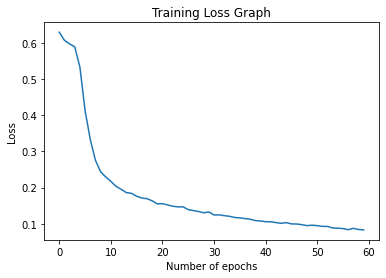

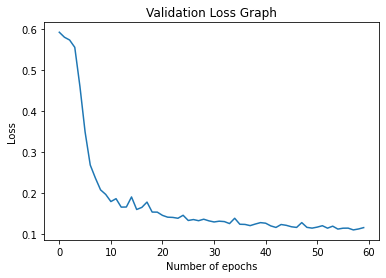

In [ ]:
# Loss Graph
plt.figure(1)
plt.plot(train_loss)
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.title('Training Loss Graph')
plt.show()
plt.figure(2)
plt.plot(valid_loss)
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.title('Validation Loss Graph')
plt.show()